# Background

The Click rate prediction dataset contains the number of clicks a particuar hotel got from using a hotel aggregator's website. The objective of this project is to try to accurately predict the click rate for unseen data. The datset contains the following fields:


* hotel_id: Unique hotel identifier
* city_id: Describes the city the hotel is located in
* clicks: The number of clicks the hotel has received in a specific timeframe
* stars: The number of stars of the hotel
* distance_to_centre: Distance ( in meters ) of the hotel to the nearest city center
* avg_proce_hotel: Average hotel price for 1 person per night
* rating: Average rating on a scale from 0 (worst)- 100 (best)
* nmbr_partners_index: describes how many partner websites show rates for this hotel, compared to the average within the       city. For example, 1.1 means 10% more than the average while 0.8 means 20% less than the average
* avg_rel_saving: average saving users achieve on this hotel by using the hotel aggregator, i.e. the relative difference       between the cheapest and most expensive deal for the hotel
* avg_rank: average position the hotel has in the list before filters are applied
    
For this project we'll make use of a Regression tree, Random Forest and a Gradient Boosted tree and compare the results to see which one makes the most accurate prediction


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,format_number, lit, desc, mean
from pyspark.ml.regression import DecisionTreeRegressor,  RandomForestRegressor, GBTRegressor
from pyspark.ml.feature import VectorAssembler,VectorIndexer, OneHotEncoder,StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from spark_tree_plotting import plot_tree



In [6]:
spark = spark.builder.appName('Clickrate').getOrCreate()

In [7]:
df = spark.read.csv('/user/a208669/Click_rate_prediction.csv',inferSchema=True,header =True)

Let's start by viewing the data

In [8]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- hotel_id: decimal(20,0) (nullable = true)
 |-- city_id: integer (nullable = true)
 |-- clicks: string (nullable = true)
 |-- stars: integer (nullable = true)
 |-- distance_to_center: integer (nullable = true)
 |-- avg_price_hotel: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- nmbr_partners_index: string (nullable = true)
 |-- avg_rel_saving: string (nullable = true)
 |-- avg_rank: string (nullable = true)



Most of the fields have been imported as strings. Let's see what's happening

In [9]:
df.show()

+---+---------+-------+------+-----+------------------+---------------+------+-------------------+--------------+--------+
|_c0| hotel_id|city_id|clicks|stars|distance_to_center|avg_price_hotel|rating|nmbr_partners_index|avg_rel_saving|avg_rank|
+---+---------+-------+------+-----+------------------+---------------+------+-------------------+--------------+--------+
|  1|155796153|    738|   256|    4|               554|            127|    73|               1.12|            17| 11.4252|
|  2|155827306|    738|    NA|    4|               624|             96|    79|               0.58|             0| 13.9176|
|  3|155858459|    738|   349|    4|               434|            137|    85|               1.57|             9|  3.3073|
|  4|155889612|    738|    NA|    4|              5391|            133|    87|               0.84|             4|    8.94|
|  5|155920765|    772|     3|    3|              3922|            120|    88|               1.06|             2|  9.5752|
|  6|155951918| 

The 'NAs' in the data resulted in some fields being imported as character fields. Let's reimport the data with an additional argument

In [10]:
df = spark.read.csv('/user/a208669/Click_rate_prediction.csv',inferSchema=True,header =True,nullValue='NA')

In [11]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- hotel_id: decimal(20,0) (nullable = true)
 |-- city_id: integer (nullable = true)
 |-- clicks: integer (nullable = true)
 |-- stars: integer (nullable = true)
 |-- distance_to_center: integer (nullable = true)
 |-- avg_price_hotel: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- nmbr_partners_index: double (nullable = true)
 |-- avg_rel_saving: integer (nullable = true)
 |-- avg_rank: double (nullable = true)



In [12]:
df.show()

+---+---------+-------+------+-----+------------------+---------------+------+-------------------+--------------+--------+
|_c0| hotel_id|city_id|clicks|stars|distance_to_center|avg_price_hotel|rating|nmbr_partners_index|avg_rel_saving|avg_rank|
+---+---------+-------+------+-----+------------------+---------------+------+-------------------+--------------+--------+
|  1|155796153|    738|   256|    4|               554|            127|    73|               1.12|            17| 11.4252|
|  2|155827306|    738|  null|    4|               624|             96|    79|               0.58|             0| 13.9176|
|  3|155858459|    738|   349|    4|               434|            137|    85|               1.57|             9|  3.3073|
|  4|155889612|    738|  null|    4|              5391|            133|    87|               0.84|             4|    8.94|
|  5|155920765|    772|     3|    3|              3922|            120|    88|               1.06|             2|  9.5752|
|  6|155951918| 

In [13]:
df.count()

832085

Much better. We see the dataset contains 832 085 observations. Let's remove the rows where the outcome variable contains Nulls. These will be the unseen data

In [14]:
unseen_data = df.drop('_c0').filter(df.clicks.isNull()) 

In [15]:
unseen_data.count()

277362

In [16]:
df2 = df.drop('_c0').dropna(subset = ['clicks'])

In [17]:
df2.count()

554723

In [18]:
277362 + 554723 == 832085

True

In [19]:
df2.columns

['hotel_id',
 'city_id',
 'clicks',
 'stars',
 'distance_to_center',
 'avg_price_hotel',
 'rating',
 'nmbr_partners_index',
 'avg_rel_saving',
 'avg_rank']

Let's split the data into a training and test set before we start exploring the data

In [20]:
train_data, test_data = df2.randomSplit([0.7,0.3],seed=7873)

In [21]:
test_data.count()

166441

In [22]:
summary_stats = train_data.describe().cache()

In [23]:
num_col = [col for col in summary_stats.columns if col != 'summary']

In [24]:
num_col

['hotel_id',
 'city_id',
 'clicks',
 'stars',
 'distance_to_center',
 'avg_price_hotel',
 'rating',
 'nmbr_partners_index',
 'avg_rel_saving',
 'avg_rank']

In [25]:
summary_stats2 = summary_stats.select(summary_stats['summary'],*(format_number(col(c).cast("float"),2).alias(c) for c in num_col))

In [26]:
summ_pd = summary_stats2.toPandas()

In [27]:
summ_pd

,summary,hotel_id,city_id,clicks,stars,distance_to_center,avg_price_hotel,rating,nmbr_partners_index,avg_rel_saving,avg_rank
0,count,"388,282.00","388,282.00","388,282.00","388,282.00","388,282.00","88,010.00","180,408.00","222,257.00","165,784.00","222,179.00"
1,mean,"50,861,707,264.00","84,491.88",20.71,0.92,"19,449.24",101.96,80.10,0.71,6.65,127.65
2,stddev,"31,166,103,552.00","114,530.29",161.65,1.45,"377,204.41",100.33,6.36,0.45,10.64,361.61
3,min,"155,796,160.00",0.00,0.00,-1.00,-1.00,6.00,38.00,0.08,0.00,1.00
4,max,"109,004,537,856.00","427,720.00","23,278.00",5.00,"17,730,972.00","8,083.00",96.00,5.28,88.00,"5,704.81"


As can be seen from the above summary statistics, there is definitely some data cleaning that needs to be done. The following issues can be identified:
* stars having a -1 value
* distance to centre having extremely large (and obvious erroneous) values and negative values in some instances. The suggestion would be to replace the implausable values with missing values
* Quite a lot of missing values for the fields: avg_price_hotel, avg_rel_saving and rating. avg_price_hotel and  avg_rel_saving are particulary concerning. More than 50% of the data is missing. In this case it will be good practive to speak to people in the business to gauge the reason why there might be so many missing values. Sometimes there might be a good reason why the data is missing for a particular entry. If no compelling reason exist, it may be better to drop the variable from the model.



Let's calculate the 1st and 99th percentiles for some of the variables that looks suspicious by using the approxQuantile function. This method implements a variation of the Greenwald-Khanna algorithm (with some speed optimizations). The algorithm was first present in [[http://dx.doi.org/10.1145/375663.375670 Space-efficient Online Computation of Quantile Summaries]]
by Greenwald and Khanna.  The third argument referes to the relative target precision to achieve (>= 0). If set to zero, the exact quantiles are computed, which could be very expensive. Since our dataset is relatively small, we'll ask for the exact quantity.

In [28]:
percentiles = [0.01,0.99]

In [29]:
train_data.approxQuantile('distance_to_center',percentiles,0)

[-1.0, 80459.0]

In [30]:
train_data.approxQuantile('avg_price_hotel',percentiles,0)

[17.0, 429.0]

In [31]:
train_data.approxQuantile('clicks',percentiles,0)

[0.0, 405.0]

In [32]:
train_data.filter(train_data['clicks'] == 23278).show()

+-----------+-------+------+-----+------------------+---------------+------+-------------------+--------------+--------+
|   hotel_id|city_id|clicks|stars|distance_to_center|avg_price_hotel|rating|nmbr_partners_index|avg_rel_saving|avg_rank|
+-----------+-------+------+-----+------------------+---------------+------+-------------------+--------------+--------+
|47843313209|   3848| 23278|    4|               469|             97|    84|               0.92|            10|  7.8648|
+-----------+-------+------+-----+------------------+---------------+------+-------------------+--------------+--------+



For the data manupulation part, let's make use of SQL commands- just to simplify and speed up things! We'll first register the train_data DataFrame as a Temporary SQL table

In [33]:
train_data.registerTempTable("train")

In [34]:
select_cols = ",".join([col for col in train_data.columns if col not in ('distance_to_center','avg_price_hotel','stars')])

In [35]:
select_cols

'hotel_id,city_id,clicks,rating,nmbr_partners_index,avg_rel_saving,avg_rank'

In [36]:
cleaned_train = sqlContext.sql("""SELECT {}, 
                                CASE WHEN distance_to_center = -1 OR distance_to_center > 80459 THEN NULL 
                                ELSE distance_to_center END AS distance_to_center ,
                                
                                CASE WHEN avg_price_hotel < 17 OR avg_price_hotel > 429 THEN NULL 
                                ELSE avg_price_hotel END AS avg_price_hotel,
                                
                                CASE WHEN stars = -1 THEN NULL 
                                ELSE stars END AS stars
                                
                                FROM train""".format(select_cols))

Let's check to make sure the data point were removed

In [37]:
cleaned_train.select('distance_to_center','avg_price_hotel','stars').describe().show()

+-------+------------------+-----------------+------------------+
|summary|distance_to_center|  avg_price_hotel|             stars|
+-------+------------------+-----------------+------------------+
|  count|            373665|            86287|            388238|
|   mean| 3912.245109924665|96.78338567802798|0.9240105296235814|
| stddev| 7435.615675110125|58.83250277657416| 1.446684925328674|
|    min|                 1|               17|                 0|
|    max|             80459|              429|                 5|
+-------+------------------+-----------------+------------------+



Looks better. Let's now look  at some correlations and plots

In [38]:
def corr_matrix(data, vars):
    corr_list = []
    nvars = len(vars)
    for i in range(nvars):
       for j in range(nvars):
        corr_list.append(data.corr(vars[i],vars[j]))
    ar = np.asarray(corr_list).reshape(nvars,nvars)
    return pd.DataFrame(ar,columns=vars,index=vars)

In [39]:
corr_matrix(data=cleaned_train, vars=num_col[2:])

,clicks,stars,distance_to_center,avg_price_hotel,rating,nmbr_partners_index,avg_rel_saving,avg_rank
clicks,1.000000,0.184843,-0.014567,0.236147,0.136134,0.200463,0.228288,-0.018487
stars,0.184843,1.000000,0.064814,0.450529,0.497149,0.519586,0.397570,0.002896
distance_to_center,-0.014567,0.064814,1.000000,0.002305,0.031682,-0.001730,0.015799,0.049509
avg_price_hotel,0.236147,0.450529,0.002305,1.000000,0.429649,0.511487,0.471765,0.072152
rating,0.136134,0.497149,0.031682,0.429649,1.000000,0.609625,0.355243,0.087540
nmbr_partners_index,0.200463,0.519586,-0.001730,0.511487,0.609625,1.000000,0.518959,-0.027761
avg_rel_saving,0.228288,0.397570,0.015799,0.471765,0.355243,0.518959,1.000000,0.034769
avg_rank,-0.018487,0.002896,0.049509,0.072152,0.087540,-0.027761,0.034769,1.000000


There is some mild correlation between some of the variables and number of clicks, albeit not very high. So the relationships may not be purely linear

In [40]:
cleaned_train.groupBy('city_id').count().orderBy(desc('count')).show()

+-------+-----+
|city_id|count|
+-------+-----+
|  25084| 2833|
|  13628| 2138|
|  13437| 2058|
|  22235| 1740|
|   3848| 1662|
|  17399| 1632|
|  15288| 1605|
|  31499| 1432|
|  31482| 1222|
|  24979| 1136|
|  23442| 1125|
|  61949| 1103|
|  66685| 1075|
|  14734|  974|
|  31720|  954|
|  15136|  819|
|   1803|  817|
|  26611|  811|
|  66674|  786|
|  26802|  779|
+-------+-----+
only showing top 20 rows



Next we'll repeat the missing values with the mean values for each city. There is multiple approaches to deal with missing values and this one might no be the best apparoach. This is purely to  illustrate how to go about doing it in Spark

In [41]:
exprs = [mean(col).alias('Ave_' + col) for col in num_col[3:]]
mean_values = cleaned_train.groupBy('city_id').agg(*exprs)

In [147]:
mean_values.take(1)

[Row(city_id=68202, Ave_stars=4.0, Ave_distance_to_center=1333.0, Ave_avg_price_hotel=104.0, Ave_rating=78.0, Ave_nmbr_partners_index=0.96, Ave_avg_rel_saving=11.0, Ave_avg_rank=1.2702)]

Let's fill in the missing values with the mean values per city_id

In [43]:
cleaned_train2 = cleaned_train.join(mean_values,on='city_id',how='left')


In [44]:
cleaned_train2.registerTempTable("cleaned_train2_sql")

cleaned_train3_sql = sqlContext.sql("""SELECT  clicks,
                                CASE WHEN rating IS NULL THEN  Ave_rating
                                ELSE rating END AS rating ,
                                
                                CASE WHEN nmbr_partners_index IS NULL THEN Ave_nmbr_partners_index
                                ELSE nmbr_partners_index END AS nmbr_partners_index,
                                
                                CASE WHEN avg_rel_saving IS NULL THEN Ave_avg_rel_saving
                                ELSE avg_rel_saving END AS avg_rel_saving,
                                
                                CASE WHEN avg_rank IS NULL THEN Ave_avg_rank
                                ELSE avg_rank END AS avg_rank,  
                                
                                CASE WHEN distance_to_center IS NULL THEN Ave_distance_to_center
                                ELSE distance_to_center END AS distance_to_center,                                
                                
                                CASE WHEN avg_price_hotel IS NULL THEN Ave_avg_price_hotel
                                ELSE avg_price_hotel END AS avg_price_hotel,    
                                
                                CASE WHEN stars IS NULL THEN round(Ave_stars,0)
                                ELSE stars END AS stars                                 
                                
                                
                                FROM cleaned_train2_sql""")



In [150]:
summary_stats = cleaned_train3_sql.describe()
summary_stats2 = summary_stats.select(summary_stats['summary'],*(format_number(col(c).cast("float"),2).alias(c) for c in cleaned_train3_sql.columns))
summ_pd = summary_stats2.toPandas()
summ_pd

,summary,clicks,rating,nmbr_partners_index,avg_rel_saving,avg_rank,distance_to_center,avg_price_hotel,stars
0,count,"388,282.00","357,020.00","367,967.00","353,430.00","367,952.00","386,490.00","291,834.00","388,282.00"
1,mean,20.71,80.18,0.69,6.57,131.68,"3,996.12",97.50,0.92
2,stddev,161.65,5.01,0.38,8.32,334.75,"7,480.30",50.46,1.45
3,min,0.00,38.00,0.08,0.00,1.00,1.00,17.00,0.00
4,max,"23,278.00",96.00,5.28,88.00,"5,704.81","80,459.00",429.00,5.00


We'll drop the remaining observations with missing values

In [46]:
cleaned_train4 = cleaned_train3_sql.dropna()

In [49]:
cleaned_train4.count()

290756

We'll take a random sample of 10 000 observations, so that the plots don't become too cluttered

In [50]:
fraction = 10000/cleaned_train4.count()
sample_data = cleaned_train4.sample(withReplacement=False,seed=42,fraction=fraction )

In [51]:
sample_data.count()

10059

In [52]:
sample_df = sample_data.toPandas()

/opt/anaconda2/envs/py345/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


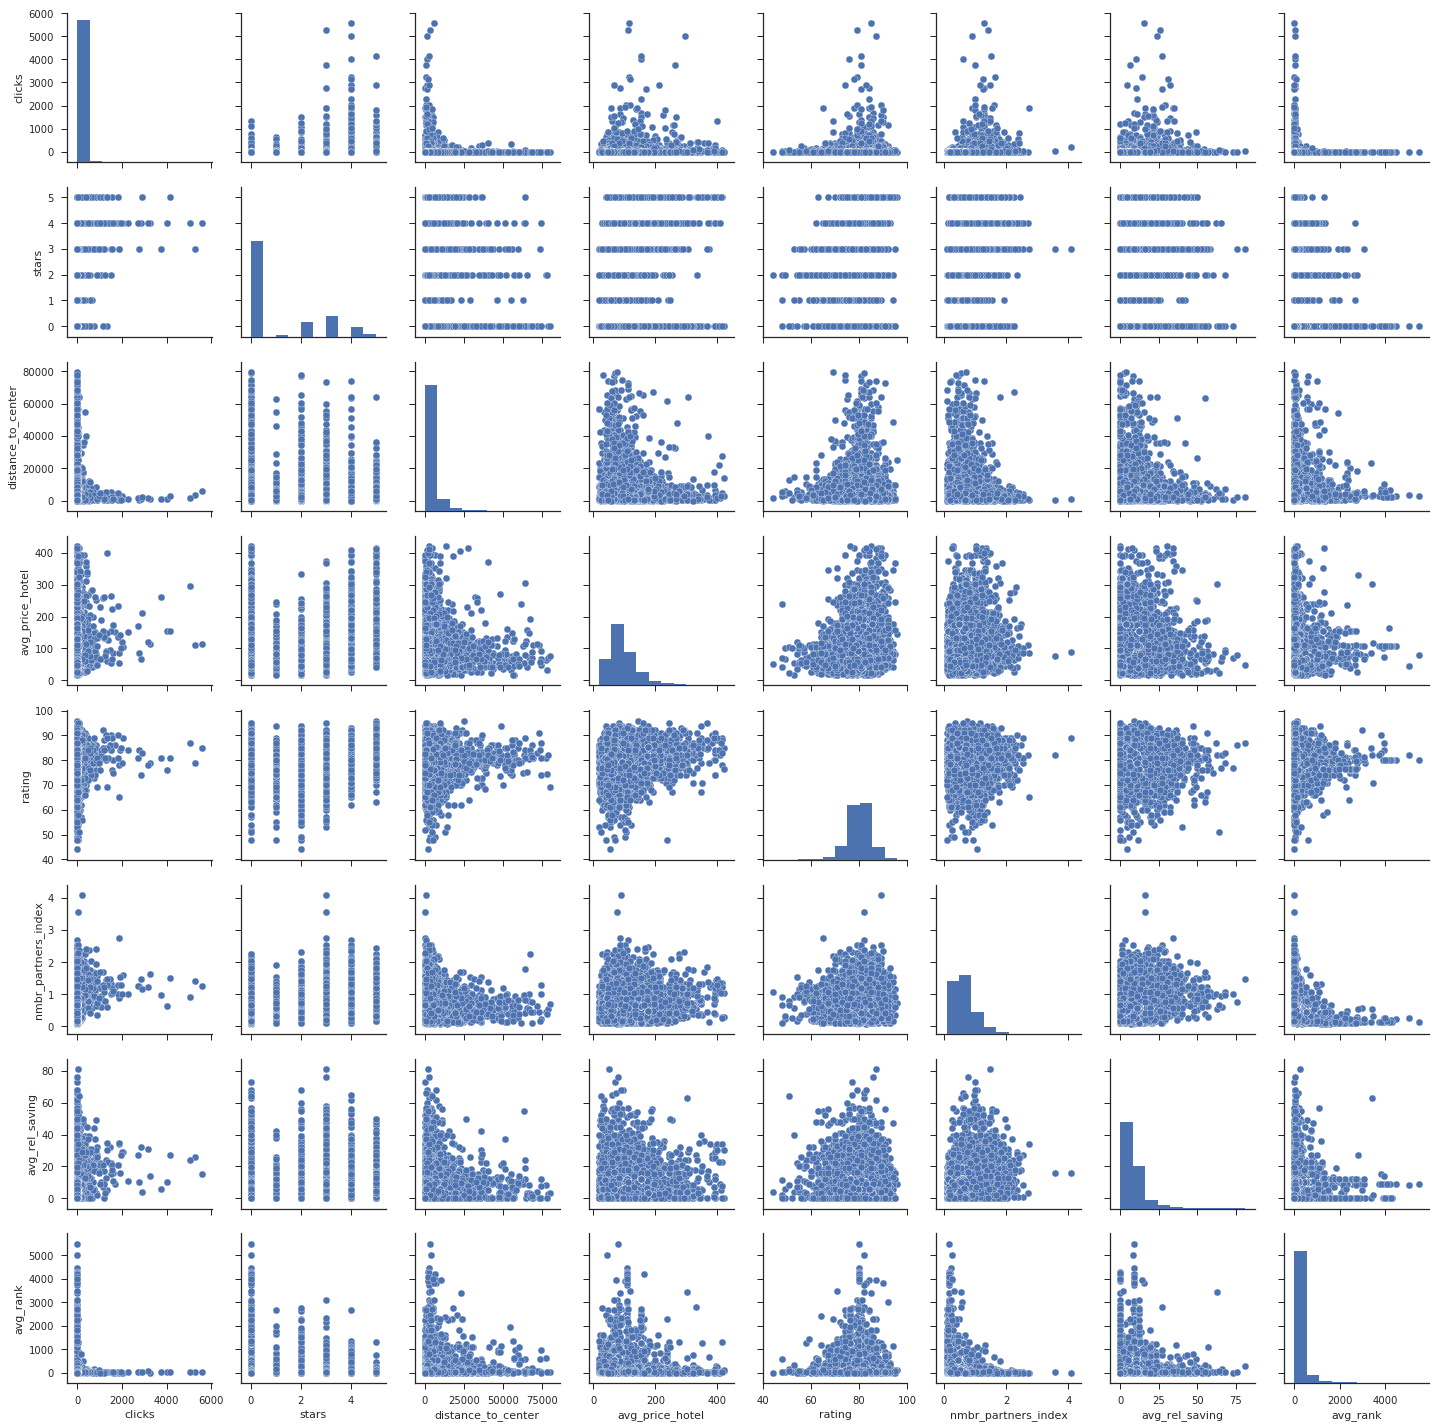

In [53]:
plt.close()
sns.set(style="ticks")
sns.pairplot(sample_df[num_col[2:]],dropna=True)
sns.plt.show()


The ralationship between the outcome variable and  explanatory variables are very difficullt to discern. Clearly non-linear relationships

/opt/anaconda2/envs/py345/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


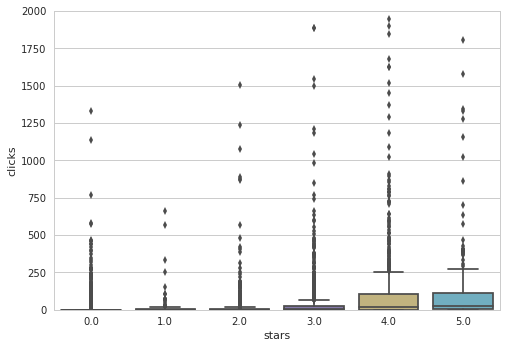

In [54]:
plt.close()
sns.set_style("whitegrid")   
plt.ylim(0, 2000)
sns.boxplot(x='stars',y="clicks",data=sample_df)
sns.plt.show()
plt.close()

For the above plot there is a clearer relationship between the number of stars of the hotel and the number of clicks. 

Now we can finally fit our models. We will put together a simple Pipeline with the following stages:
* VectorAssembler : Assemble the feature columns into a feature vector.
* VectorIndexer : Identify columns which should be treated as categorical. We'll specify maxCategories = 6 in the VectorIndexer function to treat the stars column as a categorical variable
* DecisionTreeRegressor, GBTRegressor, RandomForestRegressor : This will use the different regression tree algorithms to learn how to predict number of clicks from the feature vectors.


In [105]:
dec_tree = DecisionTreeRegressor(featuresCol='features',labelCol='clicks',seed=3624)
gbtr =GBTRegressor(featuresCol='features',labelCol='clicks',seed=3624)
rfr = RandomForestRegressor(featuresCol='features',labelCol='clicks',seed=3624,numTrees=200)


In [122]:
feature_columns = ['distance_to_center',
'avg_price_hotel',
'rating',
'nmbr_partners_index',
'avg_rel_saving',
'avg_rank',
'stars']

In [107]:
assembler = VectorAssembler(inputCols=feature_columns,outputCol='rawFeatures')

In [108]:
vectorIndexer = VectorIndexer(inputCol="rawFeatures", outputCol="features", maxCategories=6)


In [109]:
pipeline1 = Pipeline(stages=[assembler,vectorIndexer,dec_tree])
pipeline2 = Pipeline(stages=[assembler,vectorIndexer,gbtr])
pipeline3 = Pipeline(stages=[assembler,vectorIndexer,rfr])

In [110]:
dec_tree_fitted =pipeline1.fit(cleaned_train4)
gbtr_fitted = pipeline2.fit(cleaned_train4)
rfr_fitted = pipeline3.fit(cleaned_train4)

We can view which variables came out most predictive by using the featureImportances method in the Random Forest model

/opt/anaconda2/envs/py345/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


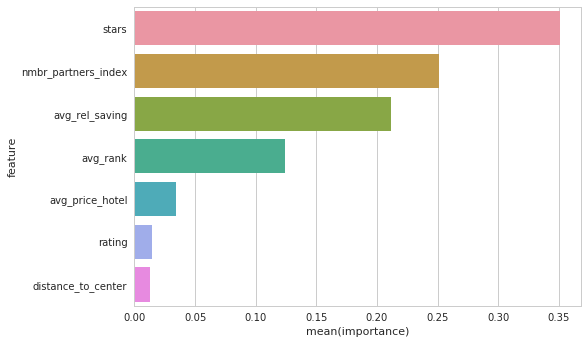

In [126]:
plt.close()
feature_imp = [x for x in rfr_fitted.stages[-1].featureImportances]

fi_for_draw = pd.DataFrame({'feature': feature_columns, 'importance':feature_imp})
fi_for_draw = fi_for_draw.sort_values(by="importance", ascending=False)
sns.set_style("whitegrid")
sns.barplot(data=fi_for_draw, x='importance', y='feature')
plt.show()



The sum of  all importances is equal to 1. The most important feautures are the number of stars of the hotel, Number of partner websites and average relative saving. Distance to center is the least predictive.

We can view the rules as follows:

In [127]:
print(dec_tree_fitted.stages[-1].toDebugString )

DecisionTreeRegressionModel (uid=DecisionTreeRegressor_4455b824349659289f91) of depth 5 with 63 nodes
  If (feature 6 in {0.0,1.0,2.0,3.0})
   If (feature 3 <= 1.0199999999999998)
    If (feature 6 in {0.0,1.0,2.0})
     If (feature 3 <= 0.8483999999999999)
      If (feature 4 <= 1.24)
       Predict: 8.472853985455583
      Else (feature 4 > 1.24)
       Predict: 3.0888972128365464
     Else (feature 3 > 0.8483999999999999)
      If (feature 4 <= 11.914285714285715)
       Predict: 11.311399945843487
      Else (feature 4 > 11.914285714285715)
       Predict: 34.00968523002421
    Else (feature 6 not in {0.0,1.0,2.0})
     If (feature 3 <= 0.66)
      If (feature 5 <= 90.08112888888887)
       Predict: 16.935261845386535
      Else (feature 5 > 90.08112888888887)
       Predict: 5.328174352495262
     Else (feature 3 > 0.66)
      If (feature 5 <= 4.9375)
       Predict: 15.023521724926495
      Else (feature 5 > 4.9375)
       Predict: 50.85322849654515
   Else (feature 3 > 1.0199999

Viewing the tree (work in progress)

In [ ]:
# tree_plot = plot_tree(dec_tree_fitted,
#                       featureNames=feature_columns,
#                       categoryNames={"stars_indexed":dec_tree_fitted.stages[0].labels},
#                       classNames='Predict',
#                       filled=True,          # With color!
#                       roundedCorners=True,  # Rounded corners in the nodes
#                       roundLeaves=True      # Leaves will be ellipses instead of rectangles
#                      )


Finally we can test the models on the test sets to see which one gives us the best prediction (lowest Root mean squared error)

In [141]:
cleaned_test2 = test_data.join(mean_values,on='city_id',how='left')
cleaned_test2.registerTempTable("cleaned_test_sql")

cleaned_test3_sql = sqlContext.sql("""SELECT  clicks,
                                CASE WHEN rating IS NULL THEN  Ave_rating
                                ELSE rating END AS rating ,
                                
                                CASE WHEN nmbr_partners_index IS NULL THEN Ave_nmbr_partners_index
                                ELSE nmbr_partners_index END AS nmbr_partners_index,
                                
                                CASE WHEN avg_rel_saving IS NULL THEN Ave_avg_rel_saving
                                ELSE avg_rel_saving END AS avg_rel_saving,
                                
                                CASE WHEN avg_rank IS NULL THEN Ave_avg_rank
                                ELSE avg_rank END AS avg_rank,  
                                
                                CASE WHEN distance_to_center IS NULL OR  distance_to_center = -1 OR distance_to_center > 80459 
                                THEN Ave_distance_to_center
                                ELSE distance_to_center END AS distance_to_center,                                
                                
                                CASE WHEN avg_price_hotel IS NULL OR avg_price_hotel < 17 OR avg_price_hotel > 429 
                                THEN Ave_avg_price_hotel
                                ELSE avg_price_hotel END AS avg_price_hotel,    
                                
                                CASE WHEN stars IS NULL or  stars = -1 THEN round(Ave_stars,0)
                                ELSE stars END AS stars                                 
                                
                                
                                FROM cleaned_test_sql""")

cleaned_test4 = cleaned_test3_sql.dropna()



In [143]:
dec_tree_predictions =dec_tree_fitted.transform(cleaned_test4)
gbtr_predictions= gbtr_fitted.transform(cleaned_test4)
rfr_predictions = rfr_fitted.transform(cleaned_test4)

In [137]:
dec_tree_predictions.printSchema()

root
 |-- clicks: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- nmbr_partners_index: double (nullable = true)
 |-- avg_rel_saving: double (nullable = true)
 |-- avg_rank: double (nullable = true)
 |-- distance_to_center: double (nullable = true)
 |-- avg_price_hotel: double (nullable = true)
 |-- stars: double (nullable = true)
 |-- rawFeatures: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [145]:
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='clicks',metricName='rmse')


rmse1 = evaluator.evaluate(dec_tree_predictions)
rmse2 = evaluator.evaluate(gbtr_predictions)
rmse3 = evaluator.evaluate(rfr_predictions)


print("Regression tree RMSE: %g" % rmse1)
print("GBTR RMSE: %g" % rmse2)
print("RF RMSE: %g" % rmse3)

Regression tree RMSE: 202.174
GBTR RMSE: 199.709
RF RMSE: 201.882
